In [11]:
from project_config import SEED, env_config
from utils.common_imports import *

from utils.logger_setup import logger

nodule_df = pd.read_csv(f"{env_config.OUT_DIR}/nodule_df.csv")

PROCESSED_NODULE_DF_NAME = "processed_nodule_df"
display(nodule_df.shape)
nodule_df.columns

(2625, 33)

Index(['index', 'pid', 'nodule_idx', 'ann_mean_diameter', 'ann_mean_volume',
       'nodule_annotation_ids', 'nodule_annotation_count', 'malignancy_scores',
       'subtlety_scores', 'consensus_centroid', 'consensus_bbox_10',
       'consensus_bbox_20', 'consensus_bbox_30', 'consensus_bbox_40',
       'consensus_bbox_50', 'consensus_bbox_60', 'consensus_bbox_70',
       'consensus_bbox_80', 'consensus_bbox_90', 'consensus_bbox_100',
       'malignancy_consensus', 'subtlety_consensus', 'cancer_label',
       'bbox_10_standardised', 'bbox_20_standardised', 'bbox_30_standardised',
       'bbox_40_standardised', 'bbox_50_standardised', 'bbox_60_standardised',
       'bbox_70_standardised', 'bbox_80_standardised', 'bbox_90_standardised',
       'bbox_100_standardised'],
      dtype='object')

# Necesarry Filtering
1) filter out nodules whos bbox exceeds the scan edge at bbox size 70

In [12]:
max_image_dim = 70
filtered_nodule_df = nodule_df.query(f"bbox_{max_image_dim}_standardised == True")
logger.info(f"removing {nodule_df.shape[0] - filtered_nodule_df.shape[0]} nodules that are not within scan. Max image dim used: {max_image_dim}")

print()
print("nodule_df shape:", nodule_df.shape)

[INFO|2228567563.py|<module>|L3] 2024-10-08 11:13:20: removing 308 nodules that are not within scan. Max image dim used: 70

nodule_df shape: (2625, 33)


# Create hold out set

In [13]:
from sklearn.model_selection import StratifiedGroupKFold

FOLDS = 10  # use ~10 percent of the data for the hold out set

sgkf = StratifiedGroupKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idxs, test_idxs) in enumerate(
    sgkf.split(
        X=filtered_nodule_df, y=filtered_nodule_df["malignancy_consensus"], groups=filtered_nodule_df["pid"]
    )
):
    hold_out_rows = filtered_nodule_df.iloc[test_idxs]["pid"]
    hold_out_pids = hold_out_rows.unique().tolist()
    logger.info(
        f"Using {len(hold_out_rows)} hold out instances (nodules)"
    )
    break

[INFO|893265133.py|<module>|L13] 2024-10-08 11:13:21: Using 254 hold out instances (nodules)


In [14]:
# create hold out df:
hold_out_df = filtered_nodule_df[filtered_nodule_df["pid"].isin(hold_out_pids)].reset_index(drop=True)
hold_out_df.to_csv(f"{env_config.OUT_DIR}/hold_out_nodule_df.csv", index=False)
print(f"hold_out_df: {hold_out_df.shape}")

# remove hold out pids from nodule_df:
filtered_nodule_df = filtered_nodule_df[~filtered_nodule_df["pid"].isin(hold_out_pids)].reset_index(drop=True)
print(f"filtered_nodule_df: {filtered_nodule_df.shape}")

hold_out_df: (254, 33)
filtered_nodule_df: (2063, 33)


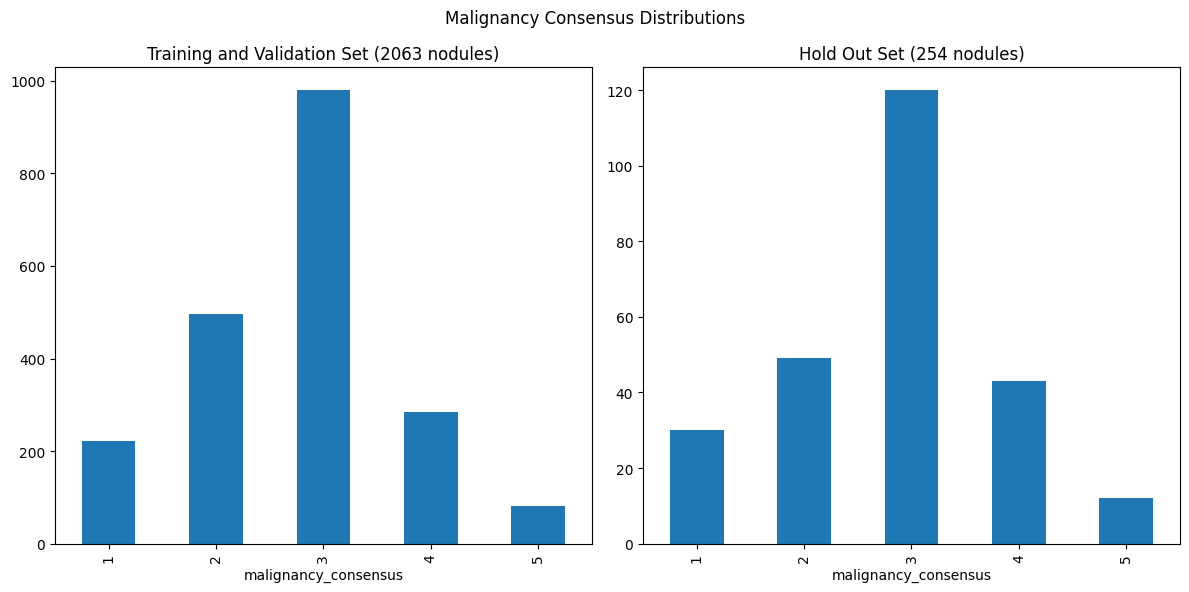

In [16]:
# investigate malignancy distribution between hold out and filtered_nodule_df:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

filtered_nodule_df["malignancy_consensus"].value_counts().sort_index().plot(kind="bar", ax=ax[0])
ax[0].set_title(f"Training and Validation Set ({len(filtered_nodule_df)} nodules)")

hold_out_df["malignancy_consensus"].value_counts().sort_index().plot(kind="bar", ax=ax[1])
ax[1].set_title(f"Hold Out Set ({len(hold_out_df)} nodules)")

plt.suptitle("Malignancy Consensus Distributions")
plt.tight_layout()
plt.show()

# Add Cross Validation Folds

In [6]:
# from preprocessing.create_cv_df import add_cv_info

# BUG: this addes back the original columns???
# but i also dont think we are going to need it.... We just add the cv in the training loop and make sure to use a SEED
# filtered_nodule_df = add_cv_info(nodule_df)

# Write out processed nodule df to file

In [17]:
try:
    filtered_nodule_df.to_csv(f"{env_config.OUT_DIR}/{PROCESSED_NODULE_DF_NAME}.csv", index=False)
except Exception as e:
    logger.error(f"Error saving nodule_df dataframe: {e}")